<a href="https://colab.research.google.com/github/alicia963900/Analyzing-Sentiment-of-Reddit-Comments-for-Content-Creators-And-Users/blob/main/BA865_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**865 Project: Analyzing Sentiment of Reddit Comments for Content Creators And Users**

# Names: 

*   Ta-Wei Wang / davidtww@bu.edu
*   Ting-Hsuan Chen / aliciac@bu.edu
*   Ting-Ann Lu / annlu@bu.edu
*   Luke Hong / hongluke@bu.edu


#*Data Source*
GoEmotions Dataset: https://github.com/google-research/google-research/tree/master/goemotions

# *Reference*
Google AI Blog: https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html

# Import Data and Data Overview

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 13.9 MB/s 
     |████████████████████████████████| 895 kB 3.8 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 6.5 MB 57.7 MB/s 
     |████████████████████████████████| 596 kB 61.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, GlobalAveragePooling1D

from tensorflow.keras.models import Model
from sklearn.model_selection import KFold, cross_val_score
import re
import string
from transformers import DistilBertTokenizer, DistilBertForMultipleChoice
import tensorflow as tf
import matplotlib.pyplot as plt
from statistics import mean
warnings.filterwarnings('ignore')
device = torch.device('cuda')

In [ ]:
# importing the dataset from a publicly accessible source
df1 = pd.read_csv("https://raw.githubusercontent.com/David855008/BA865/main/data_cleaned.csv")
df = df1.sample(frac=1).copy()
# delete the first column "Unnamed: 0"
df = df[df['example_very_unclear']==0].drop(["Unnamed: 0"], axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55001 entries, 2956 to 22318
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  55001 non-null  object 
 1   id                    55001 non-null  object 
 2   author                55001 non-null  object 
 3   subreddit             55001 non-null  object 
 4   created_utc           55001 non-null  float64
 5   example_very_unclear  55001 non-null  int64  
 6   admiration            55001 non-null  int64  
 7   amusement             55001 non-null  int64  
 8   anger                 55001 non-null  int64  
 9   annoyance             55001 non-null  int64  
 10  approval              55001 non-null  int64  
 11  caring                55001 non-null  int64  
 12  confusion             55001 non-null  int64  
 13  curiosity             55001 non-null  int64  
 14  desire                55001 non-null  int64  
 15  disappointment  

In [ ]:
# distribution of each label (calculate the sum of 1)
# we do have imbalanced data
print("Sum of each label")
df[df.columns[5:]].sum().sort_values(ascending=False)

Sum of each label


neutral                 29669
approval                12759
admiration               9646
annoyance                9509
disapproval              7997
realization              7001
disappointment           6395
optimism                 6005
curiosity                5943
joy                      5467
anger                    5376
gratitude                5179
confusion                5051
amusement                4958
sadness                  4472
love                     4235
excitement               4189
caring                   4184
disgust                  3904
surprise                 3613
desire                   2752
fear                     2070
embarrassment            1936
remorse                  1594
nervousness              1511
pride                    1096
relief                   1051
grief                     533
example_very_unclear        0
dtype: int64

#Pre Processing

In [ ]:
# text mapping to clean text data
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [ ]:
# data cleaning functions for text

def clean_text(text):
    # making text lowercase
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    
    # remove punctuation
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    # remove words containing numbers
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    # clean contraction using contraction mapping
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    
    # remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # creating a space between a word and the punctuation following it
    # ex: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    # cleans special characters present(if any)
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    # corrects common spelling errors
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    # removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    # cleaning and parsing the text
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

# apply the text in preprocessing pipeline
df['text'] = df['text'].apply(text_preprocessing_pipeline)

In [ ]:
texts = df['text'].values
labels = df.iloc[:, -28:]

In [ ]:
# We have 28 labels in total
labels

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
2956,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42722,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
14091,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
11480,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49481,0,0,0,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6583,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
44903,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
53747,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
len(texts)

55001

# **GLOVE MODEL**

## Word embedding and tokenization

* Word embedding: GloVe: https://nlp.stanford.edu/projects/glove/

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-20 18:28:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-20 18:28:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-20 18:28:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# word embeddings: using glove.6B pre-trained dataset to extract the representing vectors of words
# embeddings_index: key: word, value: vector (is a dict)
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# now we have the representing array of words
# take "feel" for example
embeddings_index['feel']

array([-4.2895e-02,  7.0671e-01,  7.5316e-01, -5.9963e-01, -8.0169e-01,
        6.0094e-01, -6.7419e-01,  2.3592e-01,  2.4005e-01, -3.6372e-01,
       -2.2720e-01,  3.6026e-02,  4.6591e-01, -3.6233e-01, -3.1325e-01,
       -3.6757e-01, -5.7255e-01,  3.0661e-01, -4.8606e-01,  6.3214e-01,
        2.8931e-01,  6.0741e-01, -8.6788e-03, -6.8206e-01, -1.8410e-01,
        2.4847e-01,  9.5902e-02, -6.9108e-01,  9.0869e-01, -3.9224e-01,
        1.4345e-01,  7.8112e-01, -1.1601e-01,  6.0312e-02,  4.6300e-01,
       -4.4191e-02,  1.4284e-01,  6.2234e-01,  2.3943e-01, -4.6815e-01,
       -2.2553e-01, -3.1920e-01,  3.1397e-01, -4.2308e-01, -4.0827e-01,
       -2.4659e-01,  5.1572e-01,  3.5494e-01,  3.1545e-01, -1.4043e+00,
       -1.6486e-01, -5.5508e-02,  1.0260e-01,  6.1515e-01,  1.2691e-01,
       -2.2379e+00,  6.9510e-01,  1.2609e-01,  1.0901e+00,  2.5953e-01,
        2.2974e-01,  1.1125e+00, -1.0156e+00, -4.1881e-01,  3.8853e-01,
       -4.8856e-02,  9.1775e-01,  1.9732e-03, -6.9162e-01, -5.89

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts)
# sequences: tokenized texts
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
textLength = 200
data = pad_sequences(sequences, maxlen=textLength)

Found 29254 unique tokens.


In [ ]:
# now we have word index of our texts
data

array([[   0,    0,    0, ...,   10,  251,  135],
       [   0,    0,    0, ...,    3,  186, 1130],
       [   0,    0,    0, ...,   27,    1,  163],
       ...,
       [   0,    0,    0, ...,  502,    4, 9324],
       [   0,    0,    0, ...,  944,   47,    7],
       [   0,    0,    0, ..., 1272,   36, 1935]], dtype=int32)

In [ ]:
# establish a matrix combining embedding vector with word index
num_words = min(20000, len(word_index))
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i >= 20000:
        continue
    # get the embedding array(from embedding_index) of each word(from word_index)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        # merge embedding vector with word index
        embedding_matrix[i] = embedding_vector

In [ ]:
# create a embedding layer which will be used in the next step
embedding_layer = Embedding(num_words,
                            100,
                            weights=[embedding_matrix],
                            input_length=textLength,
                            trainable=False)

## Defining the Model

In [ ]:
# define our model
sequence_input = Input(shape=(textLength), dtype='int32')
outputList = []
embedded_sequences = embedding_layer(sequence_input)
print(embedded_sequences.shape)
x = Conv1D(16, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(pool_size=2,strides=2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(pool_size=2,strides=2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(50, activation='relu')(x) # You go from 128 mapped features to 256 dense nodes? That's odd... 
output = Dense(28, activation='sigmoid')(x)

#for label in labels:
#    outputList.append(Dense(1, activation='sigmoid')(x))
#model = Model(inputs=sequence_input, outputs=outputList)
model = Model(inputs=sequence_input, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])
print(model.summary())

(None, 200, 100)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       multiple                  2000000   
                                                                 
 conv1d_11 (Conv1D)          (None, 198, 16)           4816      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 97, 64)            3136      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 48, 64)           0         
 1D)                                      

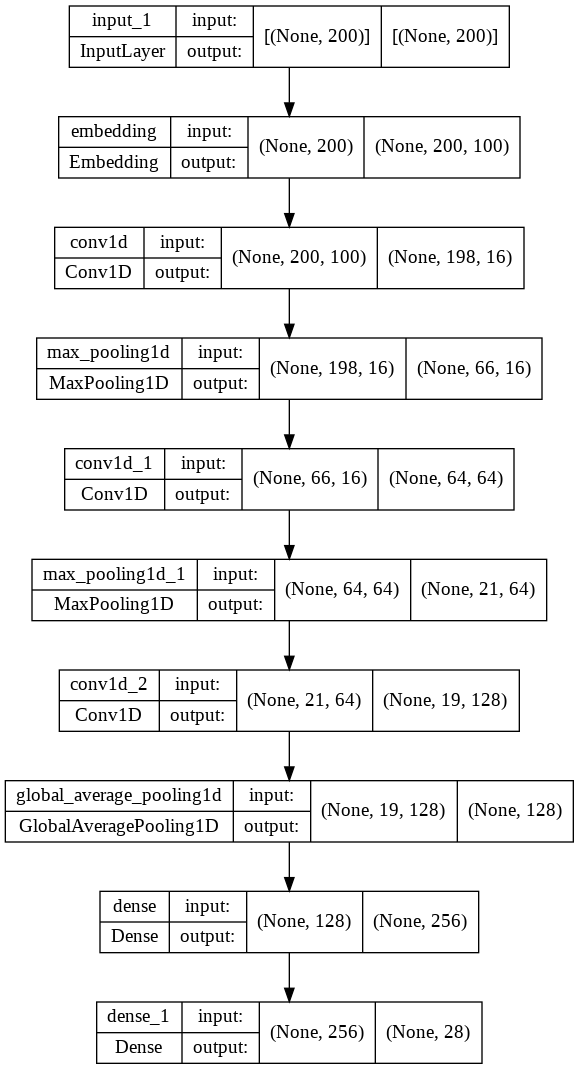

In [ ]:
keras.utils.plot_model(model, show_shapes = True)

## Fitting the Model

In [ ]:
labelsTrn.iloc[train].to_numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# split the train and test dataset
dataTrn, datTst, labelsTrn, labelsTst = train_test_split(data, labels, test_size=0.2)

In [ ]:
kfold = KFold(n_splits=3, shuffle=False)
all_acc = []
all_val_acc = []
all_loss_histories = []
all_val_loss_histories = []

In [ ]:
for train, test in kfold.split(dataTrn, labelsTrn):
    x = dataTrn[train]
    y = labelsTrn.iloc[train].to_numpy()
    x_val = dataTrn[test]
    y_val = labelsTrn.iloc[test].to_numpy()
    labelList = []
    labelList_val = []
    
    print(x.shape)
    #for label in labels.columns:
    #    labelList.append(y[label].values)
    #for label in labels.columns:
    #    labelList_val.append(y_val[label].values)
    # print(type(x),type(labelList))
    history = model.fit(x, y, validation_data=(x_val, y_val),batch_size=128,epochs=100) # modified this to pass the set of 28 labels. 
    # scores = model.evaluate(x_val, labelList_val)

    val_loss_history = history.history['val_loss']
    loss_history = history.history['loss']
    val_acc = []
    acc_history = []
    for i in history.history.keys():
      if 'acc' in i:
        if ('val' not in i) & ('dense' in i): 
          acc_history.append(history.history[i])
        elif 'val' in i:
          val_acc.append(history.history[i])
    # acc_history = history.history['val_acc']

    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    # all_acc.append(acc_history)
    # print(history.history)
    all_acc.append(acc_history)
    all_val_acc.append(val_acc)

(29333, 200)
Epoch 1/100
230/230 [==============================] - 3s 7ms/step - loss: 0.3360 - categorical_accuracy: 0.0671 - val_loss: 0.2915 - val_categorical_accuracy: 0.0679
Epoch 2/100
230/230 [==============================] - 1s 5ms/step - loss: 0.2909 - categorical_accuracy: 0.0670 - val_loss: 0.2907 - val_categorical_accuracy: 0.0680
Epoch 3/100
230/230 [==============================] - 1s 5ms/step - loss: 0.2891 - categorical_accuracy: 0.0673 - val_loss: 0.2870 - val_categorical_accuracy: 0.0694
Epoch 4/100
230/230 [==============================] - 1s 5ms/step - loss: 0.2840 - categorical_accuracy: 0.0772 - val_loss: 0.2811 - val_categorical_accuracy: 0.0950
Epoch 5/100
230/230 [==============================] - 1s 5ms/step - loss: 0.2786 - categorical_accuracy: 0.1097 - val_loss: 0.2781 - val_categorical_accuracy: 0.1248
Epoch 6/100
230/230 [==============================] - 1s 5ms/step - loss: 0.2758 - categorical_accuracy: 0.1226 - val_loss: 0.2762 - val_categorical_ac

In [ ]:
# You need to pull out averages across epochs!
val_acc_history = [np.mean([x[0][i] for x in all_val_acc]) for i in range(100)]
len(val_acc_history)

IndexError: ignored

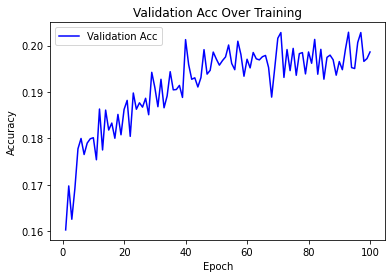

In [ ]:
plt.plot(range(1, 100+1), val_acc_history, c='blue')
#plt.plot(range(1, 100+1), history.history['val_loss'], c='blue')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Validation Acc Over Training')
plt.legend(['Validation Acc'])
plt.show()

# **BERT MODEL**

## Tokenization / Padding
Import the Bert/DistilBert model and the Tokenizer\
Process the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT 

In [ ]:
# DistilBERT
# BERT (Bidirectional Encoder Representations from Transformers)
# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertForMultipleChoice, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## BERT
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
# model_gpu = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Defining the predictors for tokenizing and the labels

In [ ]:
# df = df[:1500]
texts = df['text']
labels = df.iloc[:, -28:]

Applying the tokenizer to the text and add the padding elements to the end of the sentences.

In [ ]:
tokenized = texts.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
total = 0
words = []
for i in tokenized.values:
  for j in i:
    if j not in words:words.append(j)
  total += len(i)
  if len(i) > max_len:
      max_len = len(i)

print("total unmber of words:",total)
print("max_len of a sentence:",max_len)
print(len(words))

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

total unmber of words: 23929
max_len of a sentence: 34
3998


## Embedding

The commented rows can be uncommented if able to run on CUDA supported GPUs

In [ ]:
input_ids = torch.tensor(padded)
# input_ids = input_ids.to(device)
attention_mask = torch.tensor(attention_mask)
# attention_mask = attention_mask.to(device)

with torch.no_grad():
  last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
features_reg = last_hidden_states[0][:,0,:].cpu().numpy()

In [ ]:
labelList = []
for label in labels.columns:
    labelList.append(labels[label].values)

In [ ]:
labels.to_numpy().shape

(1500, 28)

## Logistic Regression

Split the data with a 70/30 training/testing ration.

In [ ]:
logistic_accs = []
for i in labels.columns:
  labels_temp = labels[i].values
  train_features, test_features, train_labels, test_labels = train_test_split(features_reg, labels_temp)
  lr_clf = LogisticRegression()
  lr_clf.fit(train_features, train_labels)
  logistic_accs.append(float(lr_clf.score(test_features, test_labels)))
  print(round(float(lr_clf.score(test_features, test_labels)),3),i)

0.843 admiration
0.915 amusement
0.909 anger
0.819 annoyance
0.76 approval
0.912 caring
0.901 confusion
0.904 curiosity
0.947 desire
0.851 disappointment
0.824 disapproval
0.944 disgust
0.949 embarrassment
0.939 excitement
0.965 fear
0.936 gratitude
0.995 grief
0.893 joy
0.949 love
0.957 nervousness
0.888 optimism
0.973 pride
0.829 realization
0.981 relief
0.976 remorse
0.896 sadness
0.923 surprise
0.672 neutral


## Calculate the mean of all accuracy outputs

In [ ]:
mean(logistic_accs)

0.9018095238095238